#  Credit Risk Prediction using Machine Learning and Resampling Techniques
---
**Objective:** Predict whether a loan applicant is a good or bad credit risk using multiple ML algorithms, comparing Random Oversampling and SMOTE for class imbalance handling.

**Dataset:** [UCI Statlog German Credit Data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)


In [2]:
# Install dependencies
!pip install imbalanced-learn xgboost tqdm seaborn matplotlib
# Install EBM model (Explainable Boosting Machine)
!pip install interpret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 18.7 MB/s eta 0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=40

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier


from imblearn.over_sampling import RandomOverSampler, SMOTE
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [4]:
url = '/content/drive/MyDrive/statlog/german.data'  # update path if necessary
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings',
    'employment', 'installment_rate', 'personal_status', 'guarantors', 'residence_since',
    'property', 'age', 'other_installment_plans', 'housing', 'existing_credits',
    'job', 'liable_people', 'telephone', 'foreign_worker', 'target'
]

df = pd.read_csv(url, sep=' ', names=column_names)
df['target'] = df['target'].map({1: 0, 2: 1})  # 0=Good, 1=Bad
df = pd.get_dummies(df, drop_first=True)

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Data loaded and preprocessed successfully.')

Data loaded and preprocessed successfully.


###  Define Models

In [5]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Explainable Boosting (EBM)' : ExplainableBoostingClassifier(random_state=42)


}

###  Evaluation Function

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)

        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            # Handle models without predict_proba (e.g., pyGAM)
            y_prob = model.predict(X_test)
            y_prob = np.nan_to_num(y_prob, nan=0.5, posinf=1.0, neginf=0.0)
            y_prob = np.clip(y_prob, 0, 1)

        y_pred = (y_prob >= 0.5).astype(int)

        return {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_prob)
        }

    except Exception as e:
        print(f"⚠️ {type(model).__name__} failed: {e}")
        return {
            'Accuracy': np.nan, 'Precision': np.nan, 'Recall': np.nan,
            'F1': np.nan, 'ROC-AUC': np.nan
        }


###  Sampling Methods and Model Evaluation

In [7]:
samplers = {
    'Original': None,
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42)
}

results = []
for sampler_name, sampler in samplers.items():
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    print(f'\n=== Sampling: {sampler_name} ===')
    for name, model in tqdm(models.items()):
        metrics = evaluate_model(model, X_res, y_res, X_test, y_test)
        metrics.update({'Model': name, 'Sampling': sampler_name})
        results.append(metrics)

results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Sampling', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']]
display(results_df.sort_values(['Sampling', 'ROC-AUC'], ascending=[True, False]))


=== Sampling: Original ===


 70%|███████   | 7/10 [00:01<00:00,  6.26it/s]/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:22:05] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|██████████| 10/10 [01:44<00:00, 10.49s/it]



=== Sampling: RandomOverSampler ===


 80%|████████  | 8/10 [00:01<00:00,  7.74it/s]/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:23:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|██████████| 10/10 [03:07<00:00, 18.72s/it]



=== Sampling: SMOTE ===


 80%|████████  | 8/10 [00:01<00:00,  6.15it/s]/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:26:57] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|██████████| 10/10 [05:10<00:00, 31.06s/it]


,Model,Sampling,Accuracy,Precision,Recall,F1,ROC-AUC
7,SVM (RBF),Original,0.786667,0.782609,0.400000,0.529412,0.798995
0,Logistic Regression,Original,0.770000,0.647887,0.511111,0.571429,0.796138
9,Explainable Boosting (EBM),Original,0.780000,0.662162,0.544444,0.597561,0.794180
8,XGBoost,Original,0.746667,0.589744,0.511111,0.547619,0.782804
4,AdaBoost,Original,0.733333,0.586207,0.377778,0.459459,0.780899
3,Gradient Boosting,Original,0.760000,0.640625,0.455556,0.532468,0.778995
2,Random Forest,Original,0.766667,0.750000,0.333333,0.461538,0.776534
6,Naive Bayes,Original,0.736667,0.550459,0.666667,0.603015,0.746561
5,KNN,Original,0.693333,0.484375,0.344444,0.402597,0.686958
1,Decision Tree,Original,0.650000,0.419355,0.433333,0.426230,0.588095


###  Visualization

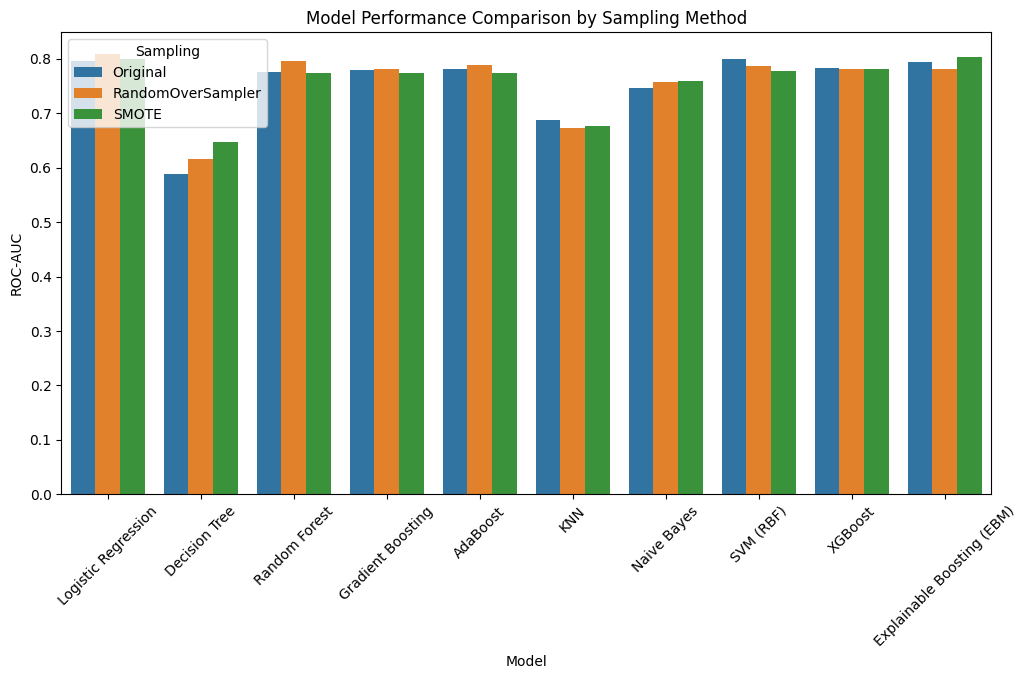

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Model', y='ROC-AUC', hue='Sampling')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison by Sampling Method')
plt.show()

###  Confusion Matrix for Best Model

Best Model: Logistic Regression | Sampling: RandomOverSampler


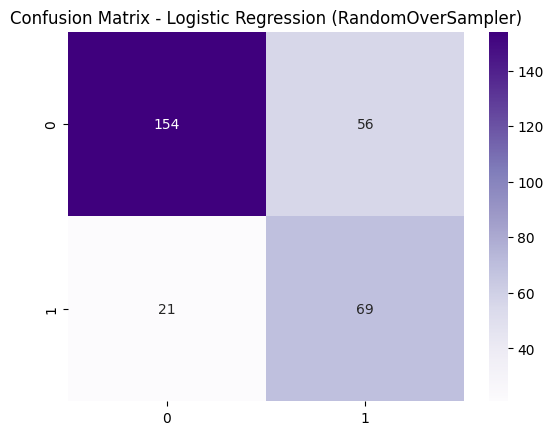

In [9]:
best = results_df.sort_values('ROC-AUC', ascending=False).iloc[0]
print(f"Best Model: {best['Model']} | Sampling: {best['Sampling']}")

sampler = samplers[best['Sampling']]
if sampler:
    X_res, y_res = sampler.fit_resample(X_train, y_train)
else:
    X_res, y_res = X_train, y_train

model = models[best['Model']]
model.fit(X_res, y_res)

if hasattr(model, 'predict_proba'):
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.5).astype(int)
else:
    y_pred = (model.predict(X_test) >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title(f"Confusion Matrix - {best['Model']} ({best['Sampling']})")
plt.show()